**CAPSTONEEE**

**DATASET**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abirafdihasburrahman","key":"8eb6dc292e21174315e4357204b90d15"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mashlyn/online-retail-ii-uci

Dataset URL: https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci
License(s): CC0-1.0
  0% 0.00/14.5M [00:00<?, ?B/s]
100% 14.5M/14.5M [00:00<00:00, 1.12GB/s]


In [ ]:
!unzip online-retail-ii-uci.zip

Archive:  online-retail-ii-uci.zip
  inflating: online_retail_II.csv    


In [ ]:
import os
os.listdir()

['.config',
 'online_retail_II.csv',
 'kaggle.json',
 'online-retail-ii-uci.zip',
 'sample_data']

In [ ]:
import pandas as pd

df = pd.read_csv("online_retail_II.csv", encoding='unicode_escape')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
df.columns = df.columns.str.replace(' ', '_')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer_ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [ ]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer_ID,243007
Country,0


In [ ]:
df.duplicated().sum()

np.int64(34335)

In [ ]:
# Hapus baris tanpa Customer ID
df = df.dropna(subset=['Customer_ID'])

# Hapus transaksi yang dibatalkan / quantity negatif
df = df[df['Quantity'] > 0]

# Hitung total harga per transaksi
df['TotalPrice'] = df['Quantity'] * df['Price']

# Konversi InvoiceDate ke datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [ ]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [ ]:
rfm = df.groupby('Customer_ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
Customer_ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


In [ ]:
rfm.describe()

,Recency,Frequency,Monetary
count,5881.000000,5881.000000,5881.000000
mean,201.457745,6.287196,3017.076888
std,209.474135,13.012879,14734.128619
min,1.000000,1.000000,0.000000
25%,26.000000,1.000000,347.800000
50%,96.000000,3.000000,897.620000
75%,380.000000,7.000000,2304.180000
max,739.000000,398.000000,608821.650000


Normalisasi

In [ ]:
Q1 = rfm['Monetary'].quantile(0.25)
Q3 = rfm['Monetary'].quantile(0.75)
IQR = Q3 - Q1
low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR

rfm = rfm[(rfm['Monetary'] >= low) & (rfm['Monetary'] <= high)]

In [ ]:
import numpy as np

rfm_log = np.log1p(rfm)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled[:5]

array([[-0.20601142,  0.66403035,  0.95138472],
       [-1.10979331,  0.37246293,  1.64516214],
       [ 0.74790731, -1.09286315, -0.63559706],
       [ 0.87639739, -1.09286315, -0.72850497],
       [-0.693319  ,  1.63335872,  1.25567746]])

Elbow Method --> Jumlah Cluster

In [ ]:
%pip install kneed

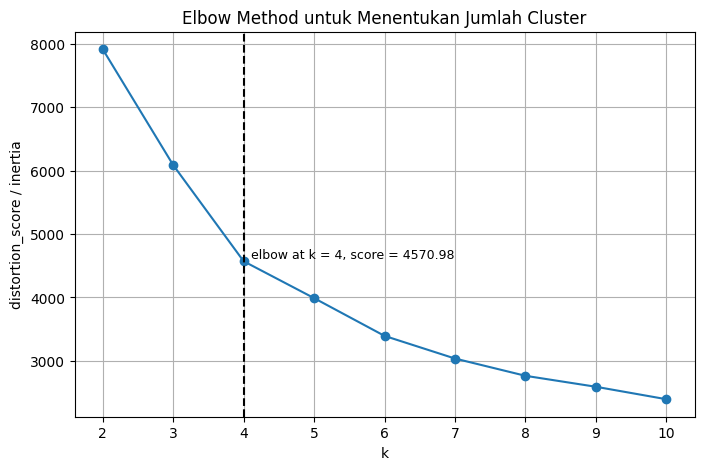

Optimal k (elbow): 4


In [ ]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt

inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

kl = KneeLocator(K, inertia, curve="convex", direction="decreasing")
optimal_k = kl.elbow
optimal_score = inertia[K.index(optimal_k)]

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')

plt.axvline(x=optimal_k, linestyle='--', color='black')

plt.text(optimal_k + 0.1, optimal_score,
         f"elbow at k = {optimal_k}, score = {optimal_score:.2f}",
         fontsize=9, va='bottom')

plt.title("Elbow Method untuk Menentukan Jumlah Cluster")
plt.xlabel("k")
plt.ylabel("distortion_score / inertia")
plt.grid(True)
plt.show()

print("Optimal k (elbow):", optimal_k)


In [ ]:
"""
from sklearn.metrics import silhouette_score

scores = {}
for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=42).fit(rfm_scaled)
    scores[k] = silhouette_score(rfm_scaled, model.labels_)
    print(k, scores[k])

best_k = max(scores, key=scores.get)
print("Best k:", best_k)
"""

'\nfrom sklearn.metrics import silhouette_score\n\nscores = {}\nfor k in range(2, 11):\n    model = KMeans(n_clusters=k, random_state=42).fit(rfm_scaled)\n    scores[k] = silhouette_score(rfm_scaled, model.labels_)\n    print(k, scores[k])\n\nbest_k = max(scores, key=scores.get)\nprint("Best k:", best_k)\n'

K-Means

In [ ]:
from sklearn.cluster import KMeans

optimal_k = 4

kmeans = KMeans(n_clusters= optimal_k, random_state=42, n_init=10)
rfm['Cluster']= kmeans.fit_predict(rfm_scaled)

rfm.head()
rfm['Cluster'].value_counts()

,count
Cluster,
0,1629
1,1363
2,1214
3,1047


In [ ]:
"""
from sklearn.cluster import KMeans

optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(rfm_scaled)
rfm['Cluster'] = kmeans.labels_

rfm.head()
"""

"\nfrom sklearn.cluster import KMeans\n\noptimal_k = 4\n\nkmeans = KMeans(n_clusters=optimal_k, random_state=42)\nkmeans.fit(rfm_scaled)\nrfm['Cluster'] = kmeans.labels_\n\nrfm.head()\n"

In [ ]:
rfm.groupby('Cluster').size()


,0
Cluster,
0,1629
1,1363
2,1214
3,1047


Rata-rata tiap cluster

In [ ]:
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
cluster_summary.style.background_gradient(cmap='Blues')

,Recency,Frequency,Monetary
Cluster,,,
0,410.097606,1.226519,258.012100
1,289.761555,3.671313,1249.596707
2,44.708402,9.127677,2756.585754
3,32.556829,2.408787,682.308139


In [ ]:
"""
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_data = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pca_data[:, 0], pca_data[:, 1],
            c=rfm['Cluster'], s=30)
plt.title(f"Visualisasi Cluster dengan PCA (k={optimal_k})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()
"""


'\nfrom sklearn.decomposition import PCA\nimport matplotlib.pyplot as plt\n\npca = PCA(n_components=2)\npca_data = pca.fit_transform(rfm_scaled)\n\nplt.figure(figsize=(8,6))\nplt.scatter(pca_data[:, 0], pca_data[:, 1],\n            c=rfm[\'Cluster\'], s=30)\nplt.title(f"Visualisasi Cluster dengan PCA (k={optimal_k})")\nplt.xlabel("PCA 1")\nplt.ylabel("PCA 2")\nplt.show()\n'

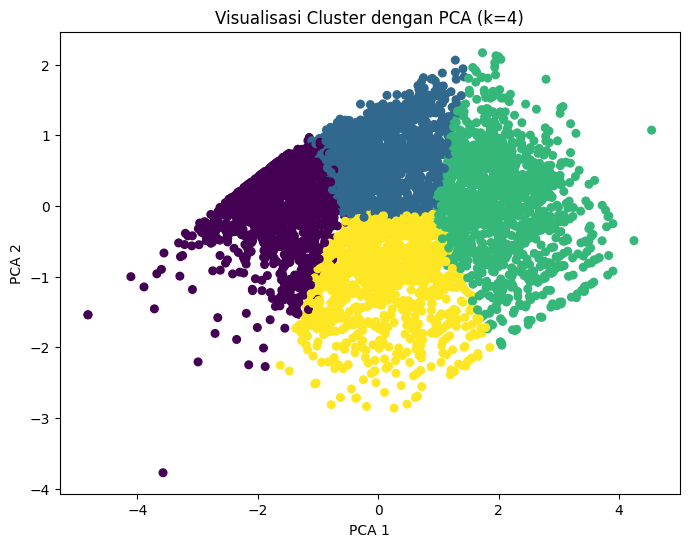

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(rfm_scaled)

rfm['pca1'] = pca_data[:, 0]
rfm['pca2'] = pca_data[:, 1]

plt.figure(figsize=(8,6))
plt.scatter(rfm['pca1'], rfm['pca2'], c=rfm['Cluster'], s=30, cmap='viridis')
plt.title(f"Visualisasi Cluster dengan PCA (k={optimal_k})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [ ]:
for i in range(4):
    print(f"\n{'='*50}")
    print(f"CLUSTER {i}")
    print(f"{'='*50}")
    cluster_data = rfm[rfm['Cluster'] == i]
    print(f"Jumlah pelanggan: {len(cluster_data)}")
    print(f"\nRata-rata RFM:")
    print(cluster_data[['Recency', 'Frequency', 'Monetary']].mean())
    print(f"\nMedian RFM:")
    print(cluster_data[['Recency', 'Frequency', 'Monetary']].median())


CLUSTER 0
Jumlah pelanggan: 1629

Rata-rata RFM:
Recency      410.097606
Frequency      1.226519
Monetary     258.012100
dtype: float64

Median RFM:
Recency      414.00
Frequency      1.00
Monetary     229.75
dtype: float64

CLUSTER 1
Jumlah pelanggan: 1363

Rata-rata RFM:
Recency       289.761555
Frequency       3.671313
Monetary     1249.596707
dtype: float64

Median RFM:
Recency       270.00
Frequency       3.00
Monetary     1038.92
dtype: float64

CLUSTER 2
Jumlah pelanggan: 1214

Rata-rata RFM:
Recency        44.708402
Frequency       9.127677
Monetary     2756.585754
dtype: float64

Median RFM:
Recency        27.00
Frequency       8.00
Monetary     2617.39
dtype: float64

CLUSTER 3
Jumlah pelanggan: 1047

Rata-rata RFM:
Recency       32.556829
Frequency      2.408787
Monetary     682.308139
dtype: float64

Median RFM:
Recency       28.00
Frequency      2.00
Monetary     604.51
dtype: float64


In [ ]:
cluster_names = {
    0: "Dormant Low Spenders",
    1: "Active Mid Spenders",
    2: "Premium Loyalists",
    3: "New Active Buyers"
}

In [ ]:
rfm['Segment'] = rfm['Cluster'].map(cluster_names)

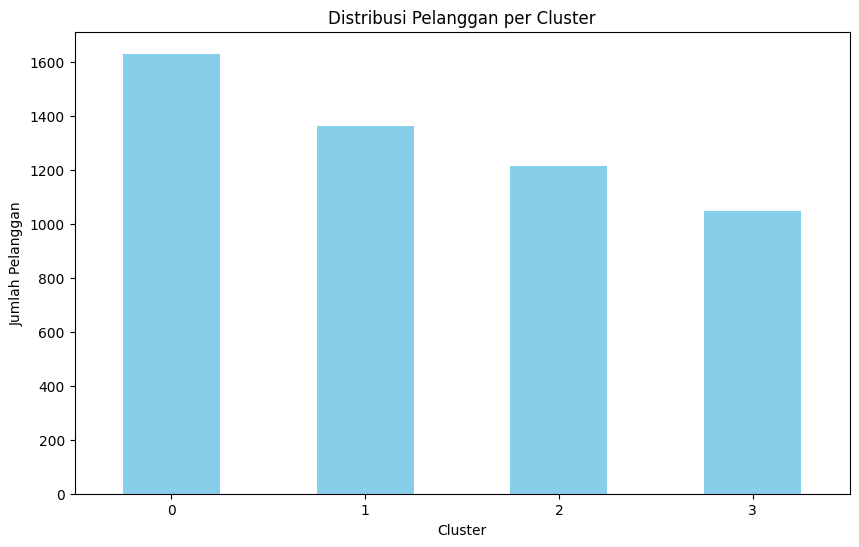

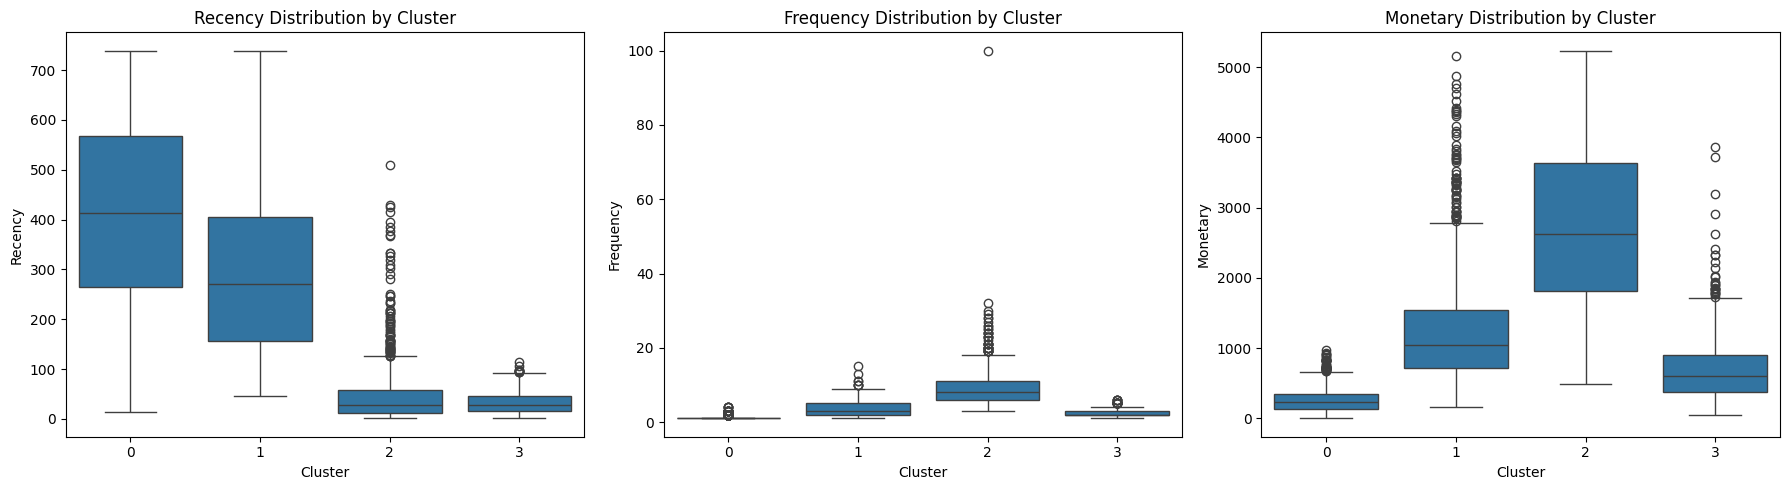

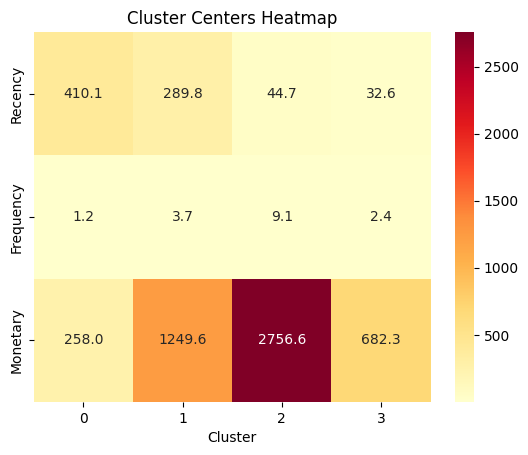

In [ ]:
import seaborn as sns

# Distribusi pelanggan per cluster
plt.figure(figsize=(10,6))
rfm['Cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Distribusi Pelanggan per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Pelanggan")
plt.xticks(rotation=0)
plt.show()

# Box plot RFM per cluster
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for idx, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    sns.boxplot(data=rfm, x='Cluster', y=col, ax=axes[idx])
    axes[idx].set_title(f'{col} Distribution by Cluster')
plt.tight_layout()
plt.show()

# Heatmap cluster centers
cluster_centers = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
sns.heatmap(cluster_centers.T, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title("Cluster Centers Heatmap")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

print(f"Silhouette Score: {silhouette_score(rfm_scaled, rfm['Cluster']):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(rfm_scaled, rfm['Cluster']):.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(rfm_scaled, rfm['Cluster']):.4f}")


Silhouette Score: 0.3616
Davies-Bouldin Index: 0.9272
Calinski-Harabasz Score: 4282.5652


In [ ]:
summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median'],
    'Cluster': 'count'
}).round(2)


In [ ]:
summary

Recency        Frequency        Monetary          Cluster
           mean median      mean median     mean   median   count
Cluster                                                          
0        410.10  414.0      1.23    1.0   258.01   229.75    1629
1        289.76  270.0      3.67    3.0  1249.60  1038.92    1363
2         44.71   27.0      9.13    8.0  2756.59  2617.39    1214
3         32.56   28.0      2.41    2.0   682.31   604.51    1047

In [ ]:
"""
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary.rename(columns={'Cluster_count': 'Customer_Count'}, inplace=True)
summary
"""

,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Customer_Count
Cluster,,,,,,,
0,410.10,414.0,1.23,1.0,258.01,229.75,1629
1,289.76,270.0,3.67,3.0,1249.60,1038.92,1363
2,44.71,27.0,9.13,8.0,2756.59,2617.39,1214
3,32.56,28.0,2.41,2.0,682.31,604.51,1047


In [ ]:
summary.to_csv("cluster_profile.csv", index=False)

In [ ]:
import joblib

joblib.dump(kmeans, "kmeans_model.pkl")


['kmeans_model.pkl']

In [ ]:
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [ ]:
rfm.to_csv("rfm_clustered.csv", index=False)
